## Descarga y formatting del CSV de los datos

In [1]:
import cv2
import numpy
import pandas
import imageio.v3 as io

from tqdm import tqdm
from typing import Optional, Union

In [2]:
data = pandas.read_csv("dataset.csv", sep = ';')
data = data.dropna(subset=['price'])
data

,id,listing_url,scrape_id,last_scraped,source,picture_url,host_id,host_url,host_name,host_since,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,Frank,2008-12-03,...,4.96,4.88,4.92,NaN,f,1,1,0,0,0.23
1,5506,https://www.airbnb.com/rooms/5506,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.89,4.55,4.75,STR-490093,f,10,10,0,0,0.68
2,6695,https://www.airbnb.com/rooms/6695,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.95,4.51,4.71,STR-491702,f,10,10,0,0,0.73
3,8789,https://www.airbnb.com/rooms/8789,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,26988,https://www.airbnb.com/users/show/26988,Anne,2009-07-22,...,4.96,4.96,4.56,NaN,f,9,9,0,0,0.24
4,10813,https://www.airbnb.com/rooms/10813,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/20b5b9c9-e1f4...,38997,https://www.airbnb.com/users/show/38997,Michelle,2009-09-16,...,5.00,5.00,4.80,NaN,f,11,11,0,0,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194,1046563598019556549,https://www.airbnb.com/rooms/1046563598019556549,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/prohost-api/H...,212359760,https://www.airbnb.com/users/show/212359760,Evonify,2018-08-29,...,5.00,5.00,5.00,Exempt: This listing is a unit that has contra...,f,77,77,0,0,1.00
7195,1046568292864752336,https://www.airbnb.com/rooms/1046568292864752336,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/prohost-api/H...,212359760,https://www.airbnb.com/users/show/212359760,Evonify,2018-08-29,...,NaN,NaN,NaN,Exempt: This listing is a unit that has contra...,f,77,77,0,0,NaN
7196,1047166785349446101,https://www.airbnb.com/rooms/1047166785349446101,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,233908696,https://www.airbnb.com/users/show/233908696,Together We,2019-01-02,...,NaN,NaN,NaN,STR-531165,t,2,2,0,0,NaN
7197,1047226383263246733,https://www.airbnb.com/rooms/1047226383263246733,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/prohost-api/H...,212359760,https://www.airbnb.com/users/show/212359760,Evonify,2018-08-29,...,NaN,NaN,NaN,Exempt: This listing is a unit that has contra...,f,77,77,0,0,NaN


In [3]:
# ¿De qué variables disponemos?
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
       'picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'ava

## Descarga de imágenes

In [4]:
def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = numpy.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=numpy.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except (IOError, ValueError) as e:  # Unavailable url / conversion error
        pass
  return images[downloaded_idxs], downloaded_idxs

Normalización y conversión en el rango [0, 1]

In [5]:
images, idxs = download_images(data['picture_url'], max_imgs=100)
images = images.astype("float32") / 255.
images.shape

100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


(100, 224, 224, 3)

Filtrado acorde en los demás datos

In [6]:
filtered_data = data.iloc[idxs]
filtered_data

,id,listing_url,scrape_id,last_scraped,source,picture_url,host_id,host_url,host_name,host_since,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,Frank,2008-12-03,...,4.96,4.88,4.92,NaN,f,1,1,0,0,0.23
1,5506,https://www.airbnb.com/rooms/5506,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.89,4.55,4.75,STR-490093,f,10,10,0,0,0.68
2,6695,https://www.airbnb.com/rooms/6695,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.95,4.51,4.71,STR-491702,f,10,10,0,0,0.73
3,8789,https://www.airbnb.com/rooms/8789,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,26988,https://www.airbnb.com/users/show/26988,Anne,2009-07-22,...,4.96,4.96,4.56,NaN,f,9,9,0,0,0.24
4,10813,https://www.airbnb.com/rooms/10813,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/20b5b9c9-e1f4...,38997,https://www.airbnb.com/users/show/38997,Michelle,2009-09-16,...,5.00,5.00,4.80,NaN,f,11,11,0,0,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3316049,https://www.airbnb.com/rooms/3316049,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/2c04b200-b5be...,16742781,https://www.airbnb.com/users/show/16742781,Jerry,2014-06-13,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
96,3343428,https://www.airbnb.com/rooms/3343428,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/a0b172a5-f206...,11228809,https://www.airbnb.com/users/show/11228809,Jonathan,2014-01-12,...,4.96,4.64,4.83,STR-538100,f,5,1,4,0,4.06
97,3441982,https://www.airbnb.com/rooms/3441982,20231218233145,2023-12-19,previous scrape,https://a0.muscache.com/pictures/8253bab3-b1fc...,13819661,https://www.airbnb.com/users/show/13819661,Jen,2014-04-02,...,4.97,4.61,4.84,STR-396299,f,4,1,3,0,2.19
98,3520353,https://www.airbnb.com/rooms/3520353,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/44429920/6578...,6508758,https://www.airbnb.com/users/show/6508758,Xerxes,2013-05-21,...,4.91,4.98,4.75,NaN,f,1,1,0,0,2.21


## Guardado de los datos para posterior uso/selección

In [7]:
numpy.save('images.npy', images)
filtered_data.to_csv('filtered_data.csv', sep=';', index=False)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!cp images.npy /content/drive/MyDrive/images_final.npy
!cp filtered_data.csv /content/drive/MyDrive/filtered_data.csv

!ls -lah images* filtered*  # Comprobación

-rw-r--r-- 1 root root 115K Apr 16 19:55 filtered_data.csv
-rw-r--r-- 1 root root  58M Apr 16 19:55 images.npy


In [10]:
# Comprobamos a abrirlos de nuevo
saved_data = pandas.read_csv("/content/drive/MyDrive/filtered_data.csv", sep=';')
saved_imgs = numpy.load("/content/drive/MyDrive/images_final.npy")
saved_data.shape, saved_imgs.shape

((100, 72), (100, 224, 224, 3))

Así, por ejemplo, cargamos y visualizamos la distribución de las etiquetas:

<Axes: >

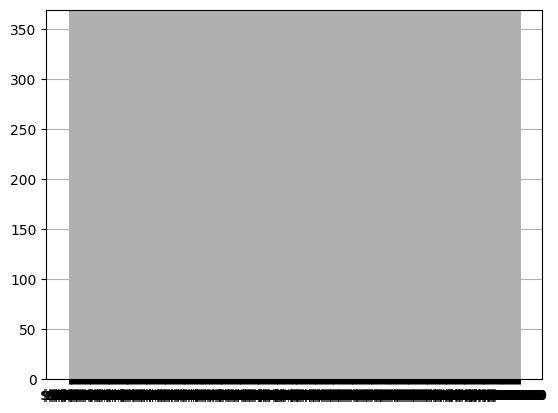

In [11]:
data['price'].hist(bins=100)

Y podemos dividir por porcentajes, para crear clases, como por ejemplo:

In [12]:
data['price'].describe()

count        7199
unique        476
top       $100.00
freq          102
Name: price, dtype: object

In [13]:
import pandas as pd

# Observar los primeros valores en la columna 'price' para detectar posibles problemas
print("Ejemplos de valores en 'price':", data['price'].head(10))

# Observar valores únicos o ejemplos de formatos inusuales
print("Valores únicos en 'price':", data['price'].unique()[:50])

Ejemplos de valores en 'price': 0    $125.00
1    $135.00
2    $179.00
3     $91.00
4     $86.00
5     $86.00
6    $266.00
7    $100.00
8    $100.00
9     $55.00
Name: price, dtype: object
Valores únicos en 'price': ['$125.00' '$135.00' '$179.00' '$91.00' '$86.00' '$266.00' '$100.00'
 '$55.00' '$80.00' '$105.00' '$140.00' '$60.00' '$275.00' '$71.00'
 '$65.00' '$328.00' '$58.00' '$62.00' '$139.00' '$195.00' '$300.00'
 '$190.00' '$187.00' '$45.00' '$75.00' '$180.00' '$175.00' '$213.00'
 '$214.00' '$689.00' '$115.00' '$236.00' '$132.00' '$226.00' '$295.00'
 '$595.00' '$200.00' '$184.00' '$113.00' '$519.00' '$539.00' '$197.00'
 '$425.00' '$120.00' '$70.00' '$72.00' '$449.00' '$450.00' '$415.00'
 '$119.00']


In [14]:
# Limpiar la columna 'price' removiendo el signo de dólar y convirtiendo a float
data['price'] = data['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Ahora podemos comprobar que la conversión ha sido exitosa
print("Valores convertidos en 'price':", data['price'].head(10))
print("Descripción de los datos:", data['price'].describe())

Valores convertidos en 'price': 0    125.0
1    135.0
2    179.0
3     91.0
4     86.0
5     86.0
6    266.0
7    100.0
8    100.0
9     55.0
Name: price, dtype: float64
Descripción de los datos: count     7199.000000
mean       183.804695
std        301.822501
min         20.000000
25%         81.000000
50%        128.000000
75%        202.000000
max      10000.000000
Name: price, dtype: float64


<Axes: >

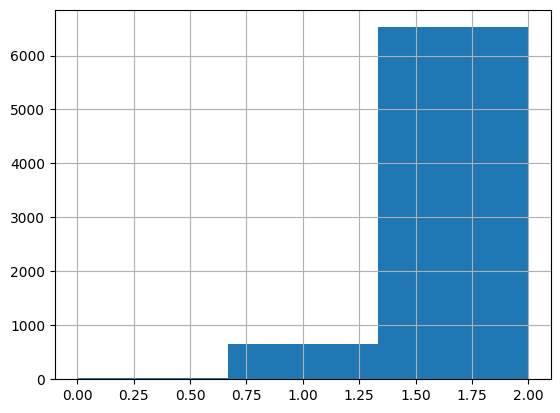

In [15]:
import pandas as pd

y_class = []
for y in data['price']:
    if y <= 32:
        y_class.append(0)  # Rango más barato
    elif 32 < y <= 55:
        y_class.append(1)  # Rango intermedio
    else:
        y_class.append(2)

y_class = pd.Series(y_class)
y_class.hist(bins=3)  # Dibuja un histograma


### **Modelo 1D/tabular:**

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Separar las características y el objetivo
y = data['price'].astype(float)
X = data.drop('price', axis=1)

# Identificar columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Mostrar las columnas para asegurar que las listas de características son correctas
print("Columnas numéricas:", numeric_features)
print("Columnas categóricas:", categorical_features)

# Crear y aplicar transformadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Esto pasa a través de cualquier columna no especificada explícitamente
)

# Aplicar preprocesamiento a las características
print("Columnas en X antes de transformar:", X.columns)
try:
    X_processed = preprocessor.fit_transform(X)
except Exception as e:
    print("Error durante la transformación:", e)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


Columnas numéricas: ['id', 'scrape_id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
Columnas categóricas: ['listing_url', 'last_scrap

In [17]:
# Verificar tipos de datos y valores únicos para una columna que pueda ser problemática
print(data['neighbourhood_group_cleansed'].unique())


[nan]


In [18]:
# Aplicar transformación a un subconjunto reducido para identificar problemas
try:
    small_transformer = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, ['latitude', 'longitude']),
            ('cat', categorical_transformer, ['host_response_time', 'room_type'])
        ],
        remainder='passthrough'
    )
    small_X_processed = small_transformer.fit_transform(X)
    print("Transformación exitosa en subconjunto reducido.")
except Exception as e:
    print("Error en la transformación del subconjunto reducido:", e)

Transformación exitosa en subconjunto reducido.


In [19]:
# Eliminar la columna 'neighbourhood_group_cleansed'
X = X.drop('neighbourhood_group_cleansed', axis=1)

# Actualizar las listas de características numéricas y categóricas
numeric_features = [col for col in numeric_features if col != 'neighbourhood_group_cleansed']
categorical_features = [col for col in categorical_features if col != 'neighbourhood_group_cleansed']

# Volver a crear y aplicar el ColumnTransformer con las columnas actualizadas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Esto pasa a través de cualquier columna no especificada explícitamente
)

# Intentar aplicar la transformación completa
try:
    X_processed = preprocessor.fit_transform(X)
    print("Transformación completa exitosa.")
except Exception as e:
    print("Error en la transformación completa:", e)


Transformación completa exitosa.


In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Dividir los datos procesados en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Definir el modelo de red neuronal
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Capa de salida para regresión
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Convertir matrices dispersas a densas
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Entrenar el modelo con datos densos
history = model.fit(X_train_dense, y_train, epochs=50, validation_split=0.2, verbose=1)

# Evaluar el modelo en el conjunto de prueba con datos densos
test_loss, test_mae = model.evaluate(X_test_dense, y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)




Epoch 1/50
144/144 [==============================] - 5s 30ms/step - loss: 122301.4141 - mae: 124.2957 - val_loss: 39923.3633 - val_mae: 82.3470
Epoch 2/50
144/144 [==============================] - 4s 26ms/step - loss: 98836.4453 - mae: 74.1622 - val_loss: 30088.5234 - val_mae: 65.1548
Epoch 3/50
144/144 [==============================] - 5s 33ms/step - loss: 87042.3516 - mae: 58.2635 - val_loss: 26577.3145 - val_mae: 63.3508
Epoch 4/50
144/144 [==============================] - 4s 26ms/step - loss: 75838.7109 - mae: 52.2358 - val_loss: 24626.4766 - val_mae: 53.7360
Epoch 5/50
144/144 [==============================] - 4s 26ms/step - loss: 64119.9219 - mae: 39.2282 - val_loss: 27195.8359 - val_mae: 65.0026
Epoch 6/50
144/144 [==============================] - 4s 29ms/step - loss: 55773.0391 - mae: 43.5080 - val_loss: 22772.2227 - val_mae: 53.3589
Epoch 7/50
144/144 [==============================] - 4s 31ms/step - loss: 49402.5781 - mae: 37.5350 - val_loss: 30675.1973 - val_mae: 63.05

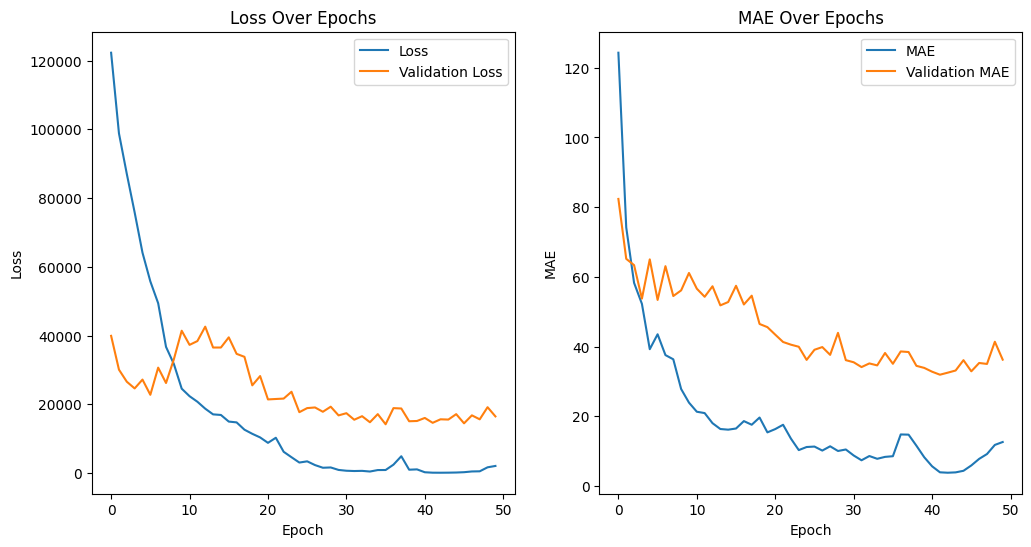

In [21]:
import matplotlib.pyplot as plt

# Visualizar la historia de entrenamiento
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

### **Modelo 2D/imágenes:**

In [22]:
import pandas as pd
import numpy as np

# Cargar datos y precios desde el archivo CSV
data_path = "dataset.csv"
data = pd.read_csv(data_path, sep=';')
print("Número total de registros antes de eliminar NaN:", len(data))

data = data.dropna(subset=['price'])
print("Número total de registros después de eliminar NaN:", len(data))

# Cargar las imágenes desde el archivo .npy
images_path = '/content/drive/MyDrive/images_final.npy'
images = np.load(images_path)
print("Número total de imágenes:", len(images))


Número total de registros antes de eliminar NaN: 7199
Número total de registros después de eliminar NaN: 7199
Número total de imágenes: 100


In [23]:
import pandas as pd
import numpy as np

# Cargar los datos
data_path = "dataset.csv"
data = pd.read_csv(data_path, sep=';')
data = data.dropna(subset=['price'])

# Cargar las imágenes
images_path = '/content/drive/MyDrive/images_final.npy'
images = np.load(images_path)

# Asumiendo que los primeros 100 registros tienen imágenes
if len(images) != 100:
    raise ValueError("El número de imágenes debería ser 100, pero es diferente.")

# Extraer los IDs que se piensa corresponden a las imágenes
image_ids = data['id'].head(100).values  # Asumiendo que 'id' es la columna de identificador

# Filtrar el DataFrame para incluir solo esas entradas
filtered_data = data[data['id'].isin(image_ids)]

# Comprobar la cantidad de entradas únicas en los datos filtrados
unique_entries = filtered_data['id'].nunique()

if unique_entries != len(images):
    print("Número de entradas únicas:", unique_entries)
    print("Se esperaban 100 entradas únicas, pero hay un desajuste.")
    # Verificar duplicados en los primeros 100 IDs
    if len(image_ids) != np.unique(image_ids).size:
        print("Hay IDs duplicados en los primeros 100 registros.")
    # Verificar si todos los IDs de image_ids están en el DataFrame
    missing_ids = [id for id in image_ids if id not in data['id'].values]
    if missing_ids:
        print("Algunos IDs especificados no existen en el DataFrame:", missing_ids)
else:
    print("Filtrado correcto. Número de registros filtrados:", len(filtered_data))


Filtrado correcto. Número de registros filtrados: 200


In [24]:
import pandas as pd
import numpy as np

# Cargar los datos
data_path = "dataset.csv"
data = pd.read_csv(data_path, sep=';')
data = data.dropna(subset=['price'])

# Cargar las imágenes
images_path = '/content/drive/MyDrive/images_final.npy'
images = np.load(images_path)

# Asumiendo que solo las primeras 100 entradas únicas sin duplicados en el DataFrame tienen imágenes correspondientes
if len(images) != 100:
    raise ValueError("El número de imágenes debería ser 100, pero es diferente.")

# Eliminar duplicados basados en 'id' para asegurar que cada 'id' sea único
data_unique = data.drop_duplicates(subset='id')

# Extraer los primeros 100 IDs únicos
if len(data_unique) < 100:
    raise ValueError("No hay suficientes registros únicos para las imágenes.")
image_ids = data_unique['id'].head(100).values

# Filtrar el DataFrame para incluir solo esas entradas
filtered_data = data_unique[data_unique['id'].isin(image_ids)]

# Verificar la cantidad de entradas filtradas
if len(filtered_data) != 100:
    raise ValueError("El filtrado de datos no es correcto después de eliminar duplicados. Debe haber exactamente 100 entradas.")

prices = filtered_data['price'].values

print("Filtrado correcto. Número de registros filtrados:", len(filtered_data))


Filtrado correcto. Número de registros filtrados: 100


In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Cargar los datos
data_path = "dataset.csv"
data = pd.read_csv(data_path, sep=';')
data = data.dropna(subset=['price'])

# Limpiar la columna 'price' removiendo el signo de dólar y convirtiendo a float
data['price'] = data['price'].str.replace('$', '').str.replace(',', '').astype(float)


# Filtrar para los primeros 100 registros después de eliminar duplicados
data_unique = data.drop_duplicates(subset='id')
if len(data_unique) < 100:
    raise ValueError("No hay suficientes registros únicos después de eliminar duplicados.")
filtered_data = data_unique.head(100)
prices = filtered_data['price'].values

# Cargar las imágenes y preprocesarlas
images_path = '/content/drive/MyDrive/images_final.npy'
images = np.load(images_path)
images = preprocess_input(images)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, prices, test_size=0.2, random_state=42)

# Cargar el modelo base pre-entrenado de ResNet50 sin la parte superior
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Crear el modelo final agregando nuevas capas
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(1, activation='linear')  # Capa de salida para la regresión
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)


94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/10
3/3 [==============================] - 22s 6s/step - loss: 60283.7305 - mae: 183.9456 - val_loss: 62490.8945 - val_mae: 200.7334
Epoch 2/10
3/3 [==============================] - 20s 6s/step - loss: 56721.1484 - mae: 173.5203 - val_loss: 58791.9805 - val_mae: 191.2953
Epoch 3/10
3/3 [==============================] - 19s 7s/step - loss: 53344.8438 - mae: 164.2470 - val_loss: 55306.6992 - val_mae: 181.9522
Epoch 4/10
3/3 [==============================] - 17s 6s/step - loss: 50445.1953 - mae: 154.6759 - val_loss: 51647.7305 - val_mae: 171.5945
Epoch 5/10
3/3 [==============================] - 20s 7s/step - loss: 47324.4922 - mae: 144.0484 - val_loss: 47840.8242 - val_mae: 160.1079
Epoch 6/10
3/3 [==============================] - 16s 6s/step - loss: 44023.9570 - mae: 132.8921 - val_loss: 43978.6250 - val_mae: 147.5420
Epoch 7/10
3/3 [==============================] - 19s 7s/step - loss: 40914.3555 - mae: 122.645

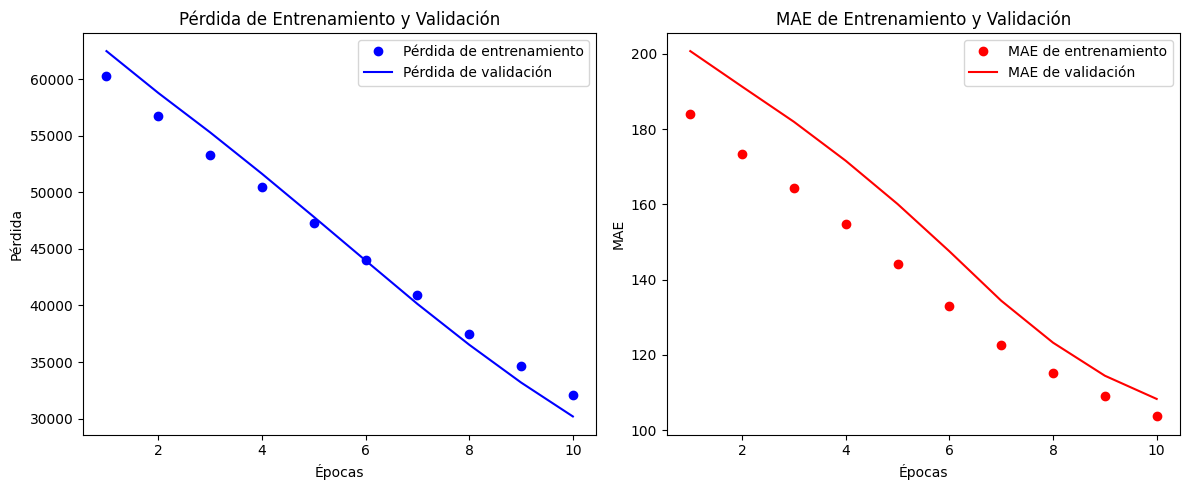

In [26]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)

# Crear gráficos
plt.figure(figsize=(12, 5))

# Gráfico para la pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico para el MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'ro', label='MAE de entrenamiento')
plt.plot(epochs, val_mae, 'r', label='MAE de validación')
plt.title('MAE de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


### **Estrategia late-fusion**

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model_1D = Sequential([
    Dense(128, activation='relu', input_shape=(224,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Capa de salida para regresión
])

In [40]:
model_1D = Sequential([
    Dense(128, activation='relu', input_shape=(16611,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

In [41]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


# Redefinir el modelo 1D para ajustarse al número correcto de características (16611 en este caso)
model_1D = Sequential([
    Dense(128, activation='relu', input_shape=(16611,)), 
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Capa de salida para regresión
])

# Compilar el modelo
model_1D.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Preprocesar y dividir los datos
X_processed = preprocessor.fit_transform(X)  
y = y.astype(np.float32)  

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Convertir X_train a un array denso
X_train_dense = X_train.toarray()

# Entrenar el modelo con el array denso
history = model_1D.fit(X_train_dense, y_train, epochs=50, validation_split=0.2, verbose=1)
y_train = y_train.values

# Convertir los datos de prueba a densos antes de la evaluación
X_test_dense = X_test.toarray()

# Evaluar el modelo con datos densos
test_loss, test_mae = model_1D.evaluate(X_test_dense, y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)


Epoch 1/50
144/144 [==============================] - 8s 49ms/step - loss: 121818.8281 - mae: 121.0428 - val_loss: 39115.8320 - val_mae: 79.6932
Epoch 2/50
144/144 [==============================] - 5s 31ms/step - loss: 98252.6172 - mae: 71.4848 - val_loss: 29684.1875 - val_mae: 70.6961
Epoch 3/50
144/144 [==============================] - 10s 67ms/step - loss: 87827.3906 - mae: 60.3084 - val_loss: 28023.6172 - val_mae: 82.1020
Epoch 4/50
144/144 [==============================] - 6s 41ms/step - loss: 76658.8672 - mae: 53.6569 - val_loss: 25770.7363 - val_mae: 68.2130
Epoch 5/50
144/144 [==============================] - 5s 33ms/step - loss: 65692.7422 - mae: 43.6607 - val_loss: 30220.7188 - val_mae: 76.3800
Epoch 6/50
144/144 [==============================] - 5s 34ms/step - loss: 56085.4219 - mae: 43.7985 - val_loss: 27778.3203 - val_mae: 61.2786
Epoch 7/50
144/144 [==============================] - 4s 29ms/step - loss: 46098.4766 - mae: 38.2879 - val_loss: 28703.5000 - val_mae: 57.9

In [45]:
# Predicciones del modelo 1D
y_pred_1D = model_1D.predict(X_test_1D)

# Predicciones del modelo 2D
y_pred_2D = model_2D.predict(X_test_2D)


y_pred_1D = y_pred_1D.flatten()
y_pred_2D = y_pred_2D.flatten()


4/4 [==============================] - 21s 4s/step


In [48]:
# Asegurar que las longitudes de y_pred_1D y y_pred_2D son las mismas
min_length = min(len(y_pred_1D), len(y_pred_2D))
y_pred_1D = y_pred_1D[:min_length]
y_pred_2D = y_pred_2D[:min_length]

# Ahora combinar las predicciones
combined_predictions = np.vstack((y_pred_1D, y_pred_2D)).T

In [50]:
print("Número de predicciones combinadas:", combined_predictions.shape[0])
print("Número de muestras en y_test:", len(y_test))

Número de predicciones combinadas: 100
Número de muestras en y_test: 1440


In [51]:
# Asegurar que y_test tiene el mismo tamaño que combined_predictions
if len(y_test) > combined_predictions.shape[0]:
    y_test = y_test[:combined_predictions.shape[0]]

# Ahora entrenar el modelo de regresión
regressor = LinearRegression()
regressor.fit(combined_predictions, y_test)

# Ahora usar el modelo de regresión para hacer la predicción final
y_pred_final = regressor.predict(combined_predictions)

In [52]:
from sklearn.linear_model import LinearRegression

# Combinar las predicciones para el entrenamiento del modelo de regresión
combined_predictions = np.vstack((y_pred_1D, y_pred_2D)).T

# Entrenar un modelo de regresión lineal para aprender cómo combinar mejor las predicciones
regressor = LinearRegression()
regressor.fit(combined_predictions, y_test)

# Usar el modelo de regresión para hacer la predicción final
y_pred_final = regressor.predict(combined_predictions)


In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluar el modelo combinado
mse = mean_squared_error(y_test, y_pred_final)
mae = mean_absolute_error(y_test, y_pred_final)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 17568.31640625
MAE: 41.088008880615234


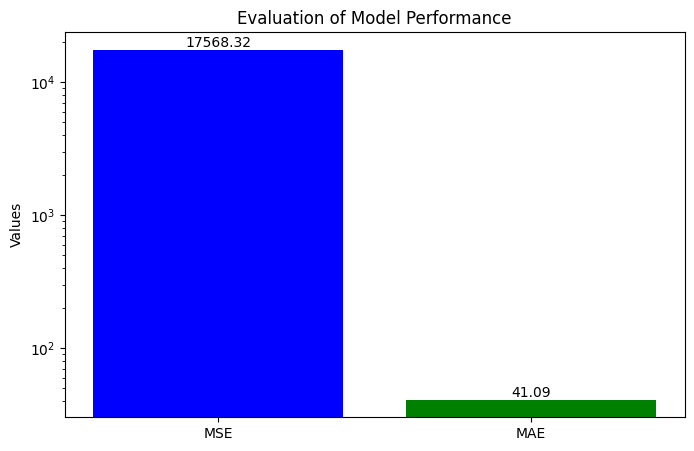

In [55]:
import matplotlib.pyplot as plt

# Nombres de las métricas para el gráfico
metrics = ['MSE', 'MAE']

# Valores correspondientes para el gráfico
values = [mse, mae]

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green'])

# Añadir título y etiquetas
plt.title('Evaluation of Model Performance')
plt.ylabel('Values')
plt.yscale('log')

# Añadir etiquetas con los valores exactos sobre cada barra para mejor claridad
for i in range(len(values)):
    plt.text(i, values[i], f'{values[i]:.2f}', ha='center', va='bottom')

# Mostrar el gráfico
plt.show()


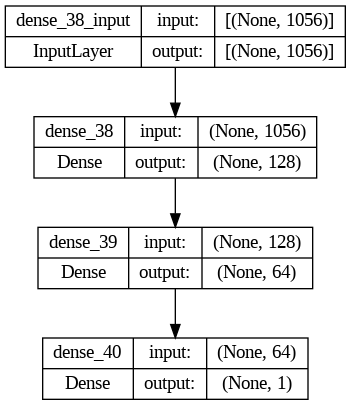

In [65]:
from tensorflow.keras.utils import plot_model

# Graficar el modelo
plot_model(fusion_model, to_file='fusion_model.png', show_shapes=True, show_layer_names=True)


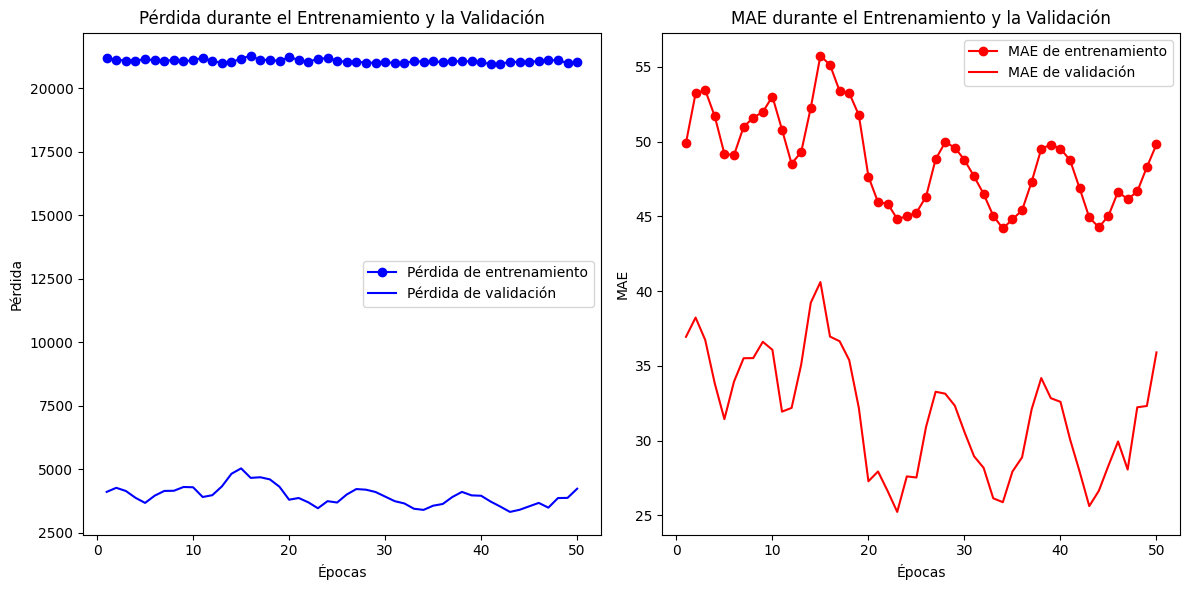

In [68]:
import matplotlib.pyplot as plt

# Extracción de métricas del objeto de historia
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history.get('mae', [])  
val_mae = history.history.get('val_mae', [])

epochs = range(1, len(loss) + 1)

# Configuración de la figura para los gráficos
plt.figure(figsize=(12, 6))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida durante el Entrenamiento y la Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de MAE
if mae and val_mae:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, 'ro-', label='MAE de entrenamiento')
    plt.plot(epochs, val_mae, 'r', label='MAE de validación')
    plt.title('MAE durante el Entrenamiento y la Validación')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

plt.tight_layout()
plt.show()


### **Estrategia early-fusion**

In [56]:
from tensorflow.keras.models import Model

# Extrae el output de la penúltima capa del modelo 1D
model_1D_embedding = Model(inputs=model_1D.input,
                           outputs=model_1D.layers[-2].output)


In [57]:
# Extrae el output de la penúltima capa del modelo 2D
model_2D_embedding = Model(inputs=model_2D.input,
                           outputs=model_2D.layers[-2].output)


In [58]:
embeddings_1D = model_1D_embedding.predict(X_test_1D)
embeddings_2D = model_2D_embedding.predict(X_test_2D)


4/4 [==============================] - 18s 4s/step


In [61]:
# Verificar y ajustar manualmente si hay discrepancias
min_length = min(embeddings_1D.shape[0], embeddings_2D.shape[0])
embeddings_1D = embeddings_1D[:min_length]
embeddings_2D = embeddings_2D[:min_length]



In [62]:
# Concatenar embeddings a lo largo del último eje después de confirmar que tienen la misma longitud
combined_embeddings = np.concatenate([embeddings_1D, embeddings_2D], axis=1)


In [63]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# Definir el modelo de fusión
fusion_model = Sequential([
    Dense(128, activation='relu', input_shape=(combined_embeddings.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1) 
])

# Compilar el modelo
fusion_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
fusion_model.fit(combined_embeddings, y_test, epochs=50, validation_split=0.2)

# Evaluar el modelo
test_loss, test_mae = fusion_model.evaluate(combined_embeddings, y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)


Epoch 1/50
3/3 [==============================] - 1s 84ms/step - loss: 65216.1680 - mae: 174.0928 - val_loss: 15821.9590 - val_mae: 106.5278
Epoch 2/50
3/3 [==============================] - 0s 17ms/step - loss: 60035.3242 - mae: 161.4465 - val_loss: 12990.0811 - val_mae: 94.7937
Epoch 3/50
3/3 [==============================] - 0s 18ms/step - loss: 54554.6133 - mae: 147.9472 - val_loss: 10185.8262 - val_mae: 81.3848
Epoch 4/50
3/3 [==============================] - 0s 18ms/step - loss: 49647.4961 - mae: 132.9573 - val_loss: 7454.9424 - val_mae: 65.7770
Epoch 5/50
3/3 [==============================] - 0s 27ms/step - loss: 43952.4453 - mae: 115.5791 - val_loss: 4968.8618 - val_mae: 49.1900
Epoch 6/50
3/3 [==============================] - 0s 17ms/step - loss: 38834.3516 - mae: 97.5174 - val_loss: 2989.8379 - val_mae: 33.8737
Epoch 7/50
3/3 [==============================] - 0s 18ms/step - loss: 34012.7070 - mae: 81.6929 - val_loss: 1876.3523 - val_mae: 27.7789
Epoch 8/50
3/3 [=========

Epoch 1/50
3/3 [==============================] - 0s 39ms/step - loss: 21177.6973 - mae: 49.9161 - val_loss: 4112.4546 - val_mae: 36.9436
Epoch 2/50
3/3 [==============================] - 0s 16ms/step - loss: 21120.4336 - mae: 53.2271 - val_loss: 4272.9229 - val_mae: 38.2305
Epoch 3/50
3/3 [==============================] - 0s 27ms/step - loss: 21088.8887 - mae: 53.4524 - val_loss: 4147.9751 - val_mae: 36.7374
Epoch 4/50
3/3 [==============================] - 0s 17ms/step - loss: 21089.3184 - mae: 51.6825 - val_loss: 3879.7500 - val_mae: 33.8163
Epoch 5/50
3/3 [==============================] - 0s 17ms/step - loss: 21143.9570 - mae: 49.1837 - val_loss: 3678.4644 - val_mae: 31.4351
Epoch 6/50
3/3 [==============================] - 0s 31ms/step - loss: 21098.7344 - mae: 49.0967 - val_loss: 3963.2437 - val_mae: 33.9466
Epoch 7/50
3/3 [==============================] - 0s 17ms/step - loss: 21086.9473 - mae: 50.9846 - val_loss: 4149.9331 - val_mae: 35.5099
Epoch 8/50
3/3 [==================

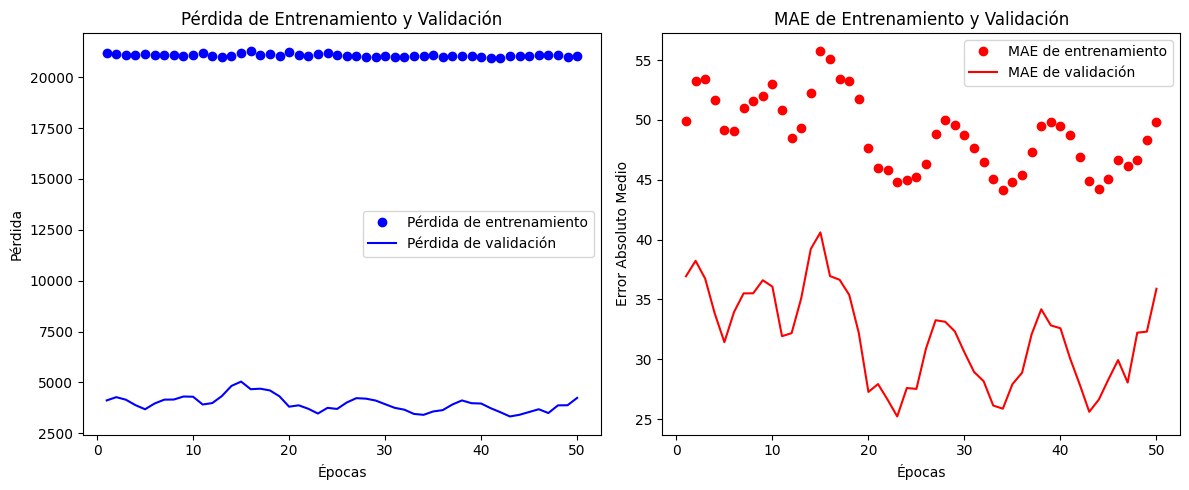

In [64]:
import matplotlib.pyplot as plt

history = fusion_model.fit(combined_embeddings, y_test, epochs=50, validation_split=0.2)

# Extracción de la pérdida y el MAE para el entrenamiento y la validación
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)

# Crear gráficos
plt.figure(figsize=(12, 5))

# Gráfico para la pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico para el MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'ro', label='MAE de entrenamiento')
plt.plot(epochs, val_mae, 'r', label='MAE de validación')
plt.title('MAE de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Error Absoluto Medio')
plt.legend()

plt.tight_layout()
plt.show()
